## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments across all data types (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# set results directory
results_dir = Path(cfg.results_dirs['mutation'],
                   'all_data_types_results',
                   'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(14400, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89804,0.715700,MAP3K1,expression,signal,42,train,0,gene
1,0.44982,0.075833,MAP3K1,expression,signal,42,test,0,gene
2,0.68112,0.311660,MAP3K1,expression,signal,42,cv,0,gene
3,0.98153,0.902770,MAP3K1,expression,signal,42,train,1,gene
4,0.85345,0.553150,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir,
                                                              'gene',
                                                              old_filenames=True)

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(7200, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.77404,0.50283,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.64596,0.26515,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.73669,0.27713,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(21600, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89804,0.715700,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.44982,0.075833,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.68112,0.311660,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98153,0.902770,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.85345,0.553150,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           metric=plot_metric)

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
2,APC,0.486833,6.515516e-12,4.886637e-10,True,RPPA,9.310990
16,CDKN2A,0.356774,1.187949e-10,8.909620e-09,True,450k methylation,8.050141
16,CDKN2A,0.396250,1.239476e-10,9.296067e-09,True,gene expression,8.031701
62,RB1,0.345183,3.298790e-10,2.474093e-08,True,27k methylation,7.606584
72,TP53,0.401734,7.428369e-10,2.203895e-08,True,gene expression,7.656809
72,TP53,0.392390,7.986374e-10,2.994890e-08,True,450k methylation,7.523619
21,EGFR,0.525068,9.880480e-10,2.203895e-08,True,gene expression,7.656809
11,BRAF,0.557306,1.175411e-09,2.203895e-08,True,gene expression,7.656809
11,BRAF,0.539797,1.637616e-09,3.422708e-08,True,450k methylation,7.465630
17,CIC,0.638257,1.825444e-09,3.422708e-08,True,450k methylation,7.465630


gene expression: 35/75
27k methylation: 34/75
450k methylation: 31/75


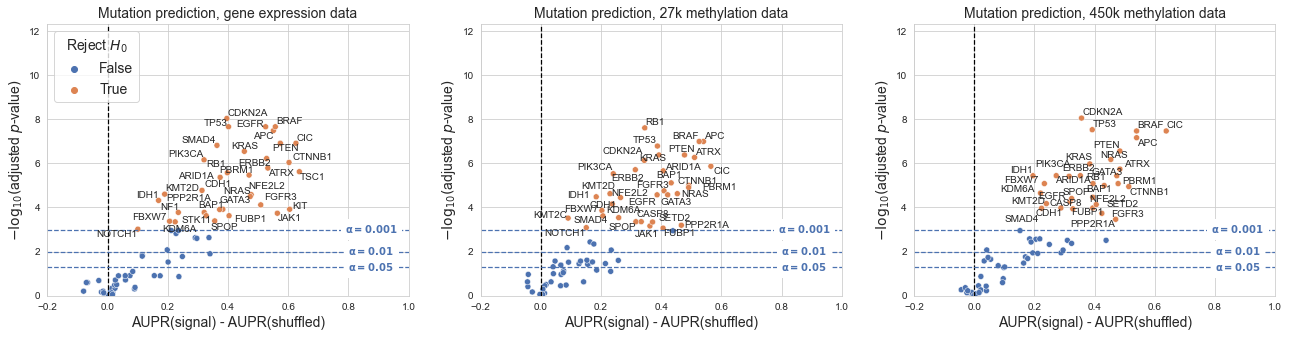

In [7]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'all_vs_shuffled_extended.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_vs_shuffled_extended.png',
                dpi=300, bbox_inches='tight')

RPPA: 26/75
microRNA: 23/75
mutational signatures: 0/75


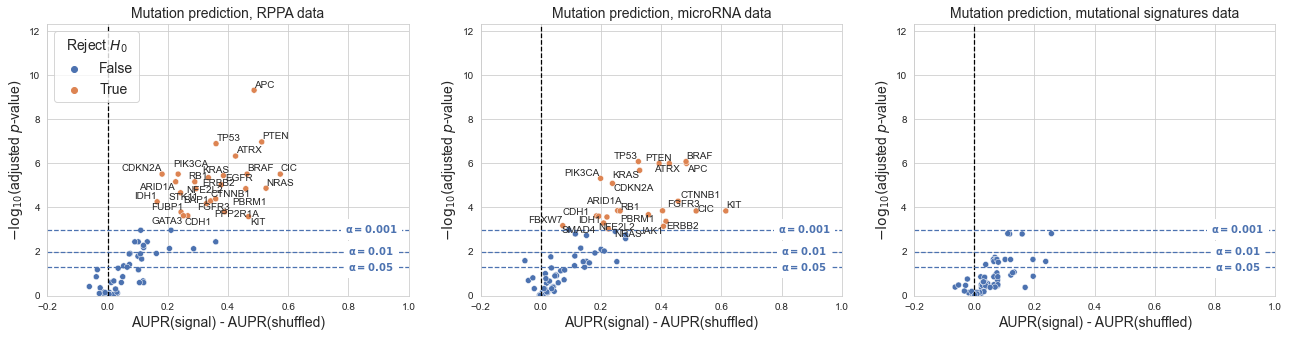

In [8]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True)
    
if SAVE_FIGS:
    plt.savefig(images_dir / 'all_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

In [9]:
# map gene/training data combinations to accept/reject null
# vs. shuffled baseline
# we want to plot this info on top of -omics comparison
id_to_sig = (all_results_df
  .loc[:, ['gene', 'training_data', 'reject_null']]
  .rename(columns={'reject_null': 'reject_null_baseline'})
)

id_to_sig.head()

,gene,training_data,reject_null_baseline
0,ALK,gene expression,False
1,AMER1,gene expression,False
2,APC,gene expression,True
3,ARID1A,gene expression,True
4,ARID1B,gene expression,False


27k methylation: 1/75
450k methylation: 0/75


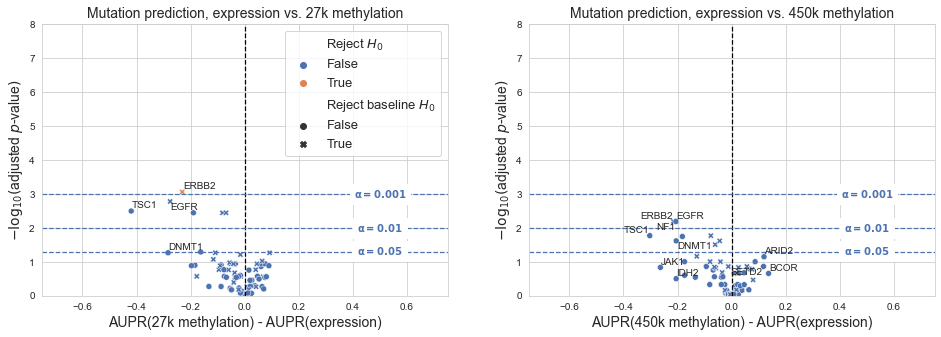

In [10]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (16, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_comparison(results_df,
                            axarr,
                            filtered_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            sig_genes=id_to_sig,
                            verbose=True)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_comparison_extended.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_comparison_extended.png',
                dpi=300, bbox_inches='tight')

RPPA: 9/75
microRNA: 9/75
mutational signatures: 26/75


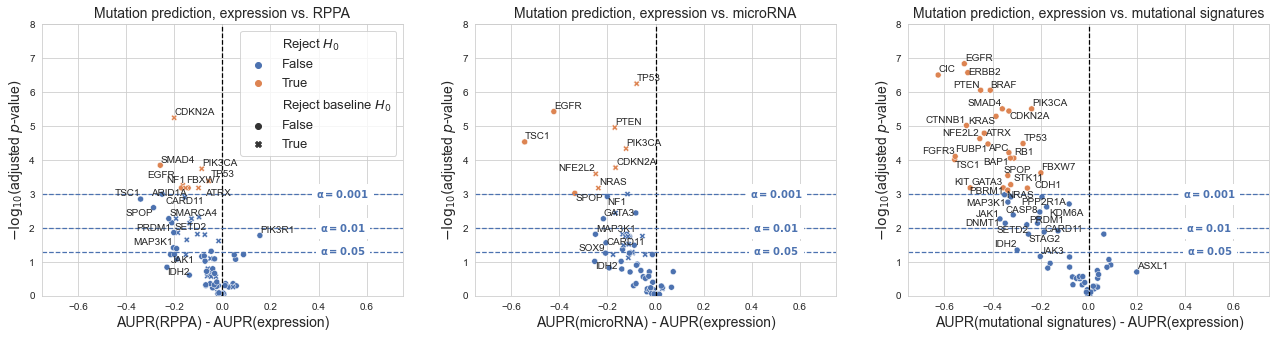

In [11]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

datasets = ['gene expression', 'RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

fig, axarr = plt.subplots(1, 3)

plu.plot_volcano_comparison(results_df,
                            axarr,
                            filtered_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            sig_genes=id_to_sig,
                            verbose=True)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_comparison.png',
                dpi=300, bbox_inches='tight')

(38,)
['APC' 'ARID1A' 'ATRX' 'BAP1' 'BRAF' 'CDH1' 'CDKN2A' 'CIC' 'CTNNB1' 'EGFR'
 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1' 'GATA3' 'IDH1' 'JAK1' 'KDM6A' 'KIT'
 'KMT2D' 'KRAS' 'NF1' 'NFE2L2' 'NOTCH1' 'NRAS' 'PBRM1' 'PIK3CA' 'PPP2R1A'
 'PTEN' 'RB1' 'SMAD4' 'SPOP' 'STK11' 'TP53' 'TSC1' 'CASP8' 'SETD2' 'KMT2C']


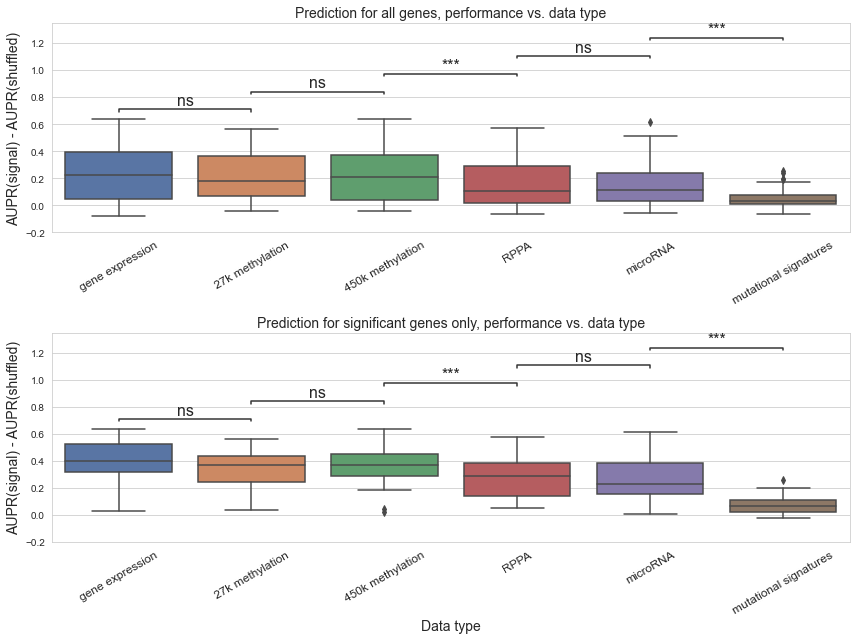

In [12]:
sns.set({'figure.figsize': (12, 9)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

tests_df = plu.plot_boxes(all_results_df,
                          axarr,
                          training_data_map,
                          metric=plot_metric,
                          orientation='v',
                          verbose=True,
                          pairwise_tests=True,
                          pairwise_box_pairs=[('gene expression', '27k methylation'),
                                              ('27k methylation', '450k methylation'),
                                              ('450k methylation', 'RPPA'),
                                              ('RPPA', 'microRNA'),
                                              ('microRNA', 'mutational signatures')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_boxes.png',
                dpi=300, bbox_inches='tight')

In [13]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
tests_df.sort_values(['gene_set', 'p_value'])

,data_type_1,data_type_2,p_value,corr_pval,reject_null,gene_set
8,27k methylation,mutational signatures,6.268301e-10,9.402451e-09,True,all
3,gene expression,microRNA,1.482674e-09,2.224012e-08,True,all
11,450k methylation,mutational signatures,2.749303e-09,4.123954e-08,True,all
4,gene expression,mutational signatures,3.028142e-09,4.542213e-08,True,all
2,gene expression,RPPA,4.902381e-08,7.353571e-07,True,all
7,27k methylation,microRNA,5.261335e-07,7.892002e-06,True,all
10,450k methylation,microRNA,5.558203e-07,8.337305e-06,True,all
14,microRNA,mutational signatures,1.545145e-06,2.317717e-05,True,all
13,RPPA,mutational signatures,1.672265e-06,2.508398e-05,True,all
9,450k methylation,RPPA,5.878363e-06,8.817545e-05,True,all


(38,)
['APC' 'ARID1A' 'ATRX' 'BAP1' 'BRAF' 'CDH1' 'CDKN2A' 'CIC' 'CTNNB1' 'EGFR'
 'ERBB2' 'FBXW7' 'FGFR3' 'FUBP1' 'GATA3' 'IDH1' 'JAK1' 'KDM6A' 'KIT'
 'KMT2D' 'KRAS' 'NF1' 'NFE2L2' 'NOTCH1' 'NRAS' 'PBRM1' 'PIK3CA' 'PPP2R1A'
 'PTEN' 'RB1' 'SMAD4' 'SPOP' 'STK11' 'TP53' 'TSC1' 'CASP8' 'SETD2' 'KMT2C']


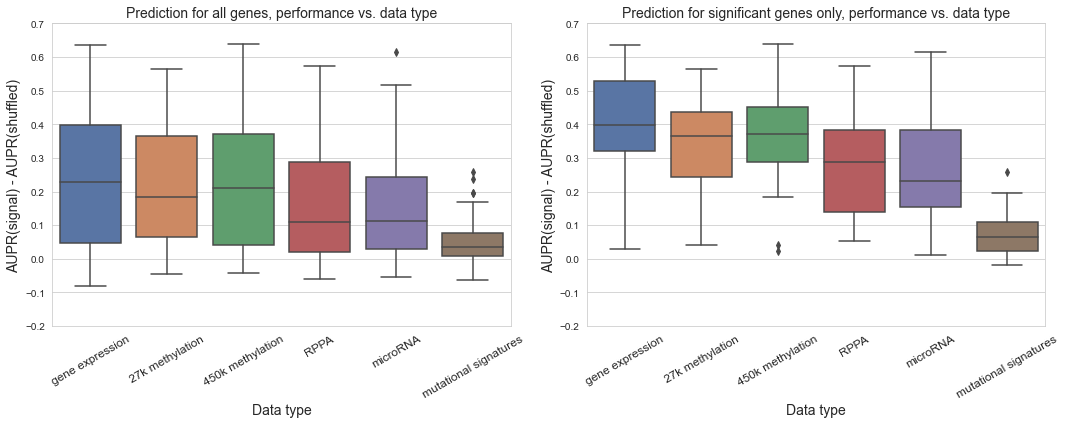

In [14]:
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

plu.plot_boxes(all_results_df,
               axarr,
               training_data_map,
               metric=plot_metric,
               verbose=True)

In [15]:
heatmap_df = (all_results_df
    .pivot(index='training_data', columns='gene', values='delta_mean')
    .reindex(training_data_map.values())
)
heatmap_df.iloc[:, :5]

gene,ALK,AMER1,APC,ARID1A,ARID1B
training_data,,,,,
gene expression,-0.012585,-0.066692,0.550894,0.373919,0.017200
27k methylation,-0.041991,0.001665,0.540233,0.406655,0.041563
450k methylation,0.017395,-0.015237,0.539900,0.395059,0.098194
RPPA,0.032558,0.117905,0.486833,0.226210,0.045553
microRNA,0.037301,0.041679,0.483887,0.255139,0.018713
mutational signatures,0.024536,-0.010729,0.195381,0.256791,0.069570


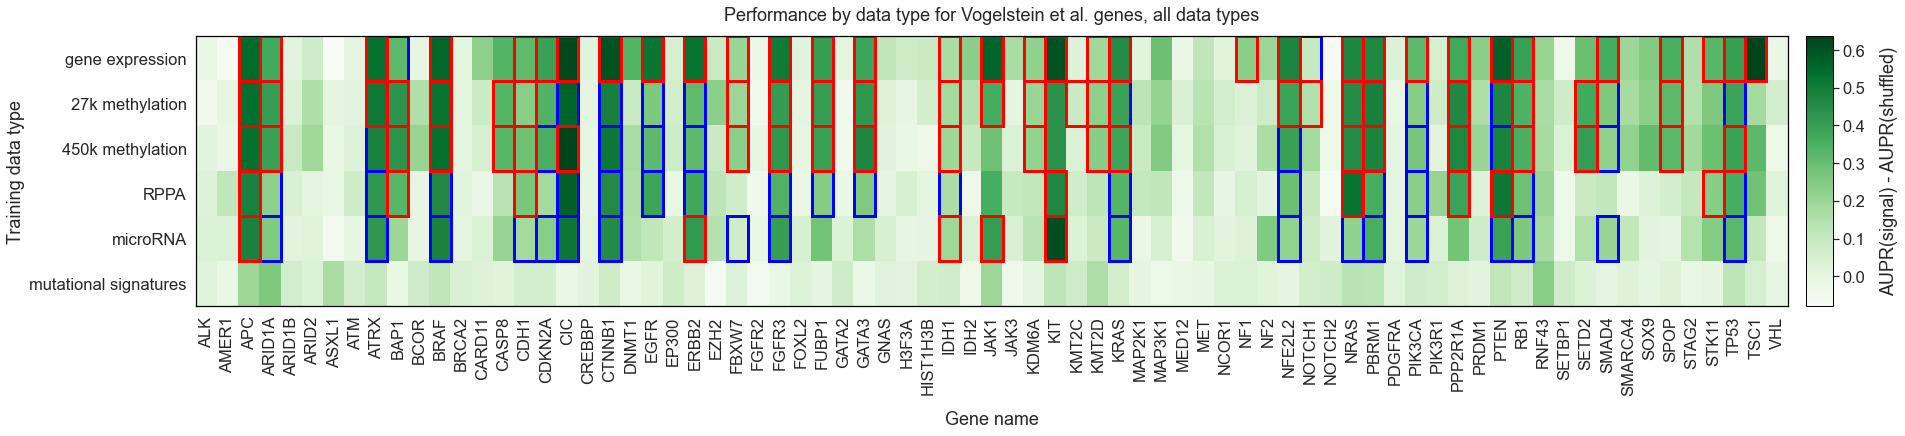

In [16]:
sns.set({'figure.figsize': (28, 6)})
sns.set_context('notebook', font_scale=1.5)

ax = plu.plot_heatmap(heatmap_df,
                      all_results_df.reset_index(drop=True),
                      different_from_best=True,
                      raw_results_df=results_df,
                      metric=plot_metric)

plt.title('Performance by data type for Vogelstein et al. genes, all data types', pad=15)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A blue square = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A red square =  significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No square/box = not significantly better than label-permuted baseline